In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
from vpower_src.utils.auxiliary_functions import *
import matplotlib.pyplot as plt

In [2]:
!pip install tabgan

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import tabgan
from tabgan.sampler import GANGenerator

In [4]:
data_dir_s =  "../Data/synthetic_data"
data_dir_r =  "../Data/split_quad"
data_tag="RD"

In [8]:
# Load data partitions and assign them to dictionary data_all
data_all = {}
#for partition in ["train", "test", "val", "lourd"]:
#    df = load_data_and_set_index(filepath=os.path.join(data_dir_s, f"{partition}.csv"), index_column_name="time_id")
#    data_all[partition+"_s"] = df
for partition in ["train", "test", "val", "lourd"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_r, f"{partition}.csv"), index_column_name="index")
    data_all[partition+"_r"] = df

if data_tag=="RD":
    data_all["train"]=data_all["train_r"]
    data_all["test"]=data_all["test_r"]
else:
    data_all["train"]=   pd.concat([data_all["train_r"], data_all["train_s"]])
    data_all["test"] = pd.concat([data_all["test_r"], data_all["test_s"]])

#data_all["train"].groupby("flight")
data_flight1 = {}
data_flight1["train"] = data_all["train"].loc[data_all["train"]["flight"] == 1]
data_flight1["test"] = data_all["test"].loc[data_all["test"]["flight"] == 1]
data_flight1["train"]
    
    

,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
112,2019-04-07 10:13:00,1,0.00,1.4,37.0,24.178350,0.389637,-79.782396,40.458047,270.407091,...,-0.000479,0.033248,-0.114812,-9.824341,4,0,25,R5,9.420778,9.420778
113,2019-04-07 10:13:00,1,0.21,1.4,36.0,23.517269,6.154673,-79.782396,40.458047,270.432353,...,0.011397,0.042173,-0.108319,-9.837841,4,0,25,R5,144.741104,144.741104
114,2019-04-07 10:13:00,1,0.31,1.4,42.0,24.109488,1.025779,-79.782396,40.458047,270.433609,...,0.017794,0.005411,-0.188141,-9.812851,4,0,25,R5,24.731003,24.731003
115,2019-04-07 10:13:00,1,0.50,1.4,42.0,24.189619,0.278312,-79.782396,40.458047,270.459037,...,-0.005043,0.034055,-0.114786,-9.808225,4,0,25,R5,6.732263,6.732263
116,2019-04-07 10:13:00,1,0.61,1.3,41.0,24.192123,0.389637,-79.782396,40.458047,270.460150,...,-0.012929,0.008335,-0.094107,-9.812603,4,0,25,R5,9.426145,9.426145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2019-04-07 10:13:00,1,169.10,1.7,92.0,22.500603,5.033473,-79.782354,40.458037,268.150388,...,0.022862,0.264301,0.581728,-9.760308,4,0,25,R5,113.256177,113.256177
1240,2019-04-07 10:13:00,1,169.20,1.7,90.0,22.493092,5.089135,-79.782354,40.458037,268.170896,...,-0.011390,0.207800,0.540354,-9.742634,4,0,25,R5,114.470383,114.470383
1241,2019-04-07 10:13:00,1,169.30,1.7,92.0,22.498098,5.025521,-79.782354,40.458037,268.153808,...,-0.000938,0.246509,0.592650,-9.784649,4,0,25,R5,113.064672,113.064672


In [9]:
input_features = [
#"time_start",
#"flight",
"time",
"wind_speed",
"wind_angle",
#"battery_voltage",
#"battery_current",
#"position_x",
#"position_y",
"position_z",
"angular_z",
"orientation_x",
"orientation_y",
"orientation_z",
"orientation_w",
"velocity_x",
"velocity_y",
"velocity_z",
"angular_x",
"angular_y",
"linear_acceleration_x",
"linear_acceleration_y",
"linear_acceleration_z",
#"speed",
"payload",
#"altitude",
#"route"
]

target = "power_smoothed"

In [10]:
# Trying to create synthetic datas from only flight 1

df_x_train_flight1 = pd.DataFrame(data_flight1["train"][input_features])
df_x_test_flight1 = pd.DataFrame(data_flight1["test"][input_features])
df_y_train_flight1 = pd.DataFrame(data_flight1["train"][target])

gen_x, gen_y = GANGenerator(gen_x_times=1, cat_cols=None,
           bot_filter_quantile=0.001, top_filter_quantile=0.999, \
              is_post_process=False,
           adversarial_model_params={
               "metrics": "rmse", "max_depth": 2, "max_bin": 100, 
               "learning_rate": 0.02, "random_state": \
                42, "n_estimators": 500,
           }, pregeneration_frac=2, only_generated_data=False,\
           gan_params = {"batch_size": 500, "patience": 25, \
          "epochs" : 250,}).generate_data_pipe(df_x_train_flight1, df_y_train_flight1,\
          df_x_test_flight1, deep_copy=True, only_adversarial=False, \
          use_adversarial=True)


[LightGBM] [Info] Number of positive: 190, number of negative: 189
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 379, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501319 -> initscore=0.005277
[LightGBM] [Info] Start training from score 0.005277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [7]:
# Creating synthetic datas from all the flights at once

df_x_train = data_all["train"][input_features]
df_x_test = data_all["test"][input_features]
df_y_train = data_all["train"][target]

# Create dataframe versions for tabular GAN
df_x_train = pd.DataFrame(df_x_train)
df_y_train = pd.DataFrame(df_y_train)
df_x_test = pd.DataFrame(df_x_test)


gen_x, gen_y = GANGenerator(gen_x_times=1, cat_cols=None,
           bot_filter_quantile=0.001, top_filter_quantile=0.999, \
              is_post_process=False,
           adversarial_model_params={
               "metrics": "rmse", "max_depth": 2, "max_bin": 100, 
               "learning_rate": 0.02, "random_state": \
                42, "n_estimators": 500,
           }, pregeneration_frac=2, only_generated_data=False,\
           gan_params = {"batch_size": 500, "patience": 25, \
          "epochs" : 250,}).generate_data_pipe(df_x_train, df_y_train,\
          df_x_test, deep_copy=True, only_adversarial=False, \
          use_adversarial=True)

KeyboardInterrupt: 

In [11]:
gen_y

0       449.671345
1       506.301456
2       432.634693
3       394.333460
4       174.708715
           ...    
2440    441.938658
2441    462.074180
2442    490.105416
2443    469.279843
2444    461.356724
Name: power_smoothed, Length: 2445, dtype: float64

In [12]:
gen_x

,time,wind_speed,wind_angle,position_z,angular_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_y,velocity_z,angular_x,angular_y,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,payload
0,78.547829,7.558194,462.147566,287.662340,0.727046,-0.002151,-0.046381,-0.663841,0.362422,-0.739855,-0.676114,2.671019,1.482202,0.107614,-0.638543,-0.050224,-10.399222,0
1,152.220336,7.139825,264.185091,268.421785,-0.226153,-0.072586,0.056000,-0.196430,0.809694,-6.200473,-0.013815,2.428948,0.991162,0.681947,2.266073,0.438807,-10.574085,0
2,145.258914,7.682484,381.910541,278.645038,1.867322,-0.107931,-0.121396,-0.212691,0.280912,-1.331021,-0.410902,2.421733,0.123243,0.160531,-0.415186,0.131249,-10.148961,0
3,62.642603,7.359064,414.620436,272.675618,0.102403,-0.035630,-0.069658,-0.835107,0.771329,-3.600630,3.384601,1.229248,-0.161273,0.121324,-1.039762,0.230053,-8.963998,0
4,97.316564,5.177767,215.098876,277.067100,-0.312078,-0.040209,-0.014792,-0.943301,1.261904,-0.879884,-0.832250,1.513763,0.441694,0.277187,-1.388063,-0.075196,-9.967484,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,121.500000,6.200000,211.000000,289.080878,0.039772,0.017665,-0.042102,0.950459,0.307479,-0.603651,3.924489,0.319996,-0.021647,-0.167524,-0.680073,0.464416,-9.537086,0
2441,156.500000,2.600000,99.000000,278.658131,0.051931,0.026995,0.013723,-0.157238,0.987096,0.096724,-0.020567,-0.984727,0.027175,-0.011633,0.412478,-0.347105,-9.908867,0
2442,154.500000,2.900000,106.000000,280.788722,0.054870,0.031722,0.012211,-0.151969,0.987801,0.095567,-0.101274,-1.059605,-0.011912,-0.059386,0.421103,-0.201983,-9.969829,0
2443,19.510000,3.000000,73.000000,294.233803,0.015343,0.137134,0.055775,-0.258678,0.954552,-3.323143,-0.568483,-0.814982,0.308121,-0.091030,0.402371,0.443022,-9.431578,0


In [34]:
#store_path = "models/DA"
#torch.save(model.state_dict(), os.path.join(store_path, "da_GAN_power.pth"))

#gen_x.to_csv('gen_x.csv')
#gen_x.to_csv('gen_y.csv')

NameError: name 'GANgenerator' is not defined

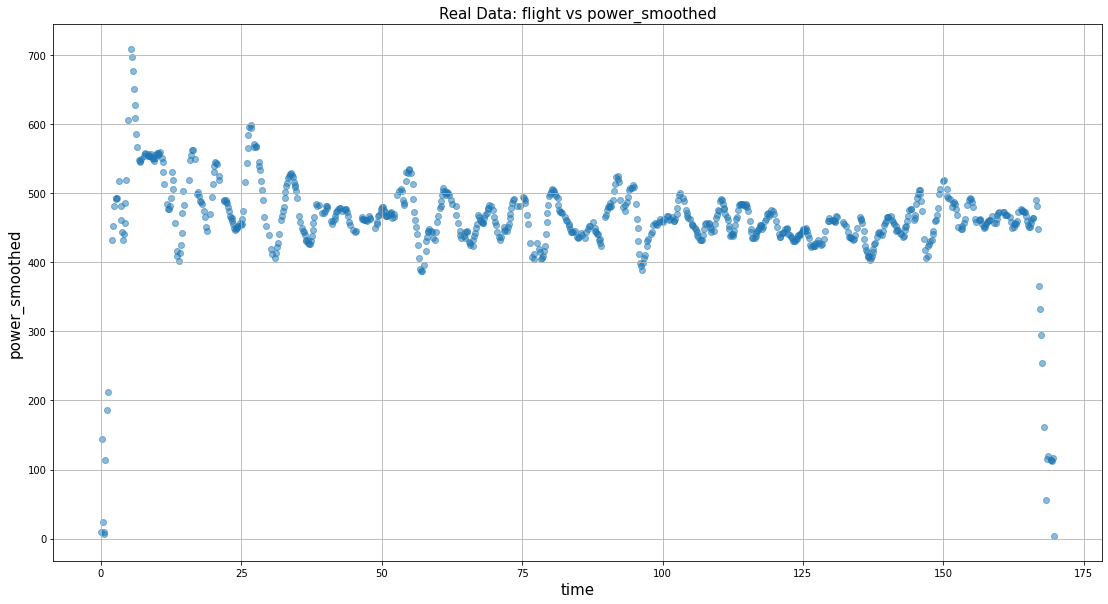

In [14]:
# Displaying real data graph

df1=data_flight1["train"]

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
ax.scatter(df1['time'], df1['power_smoothed'], alpha=0.5)

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('power_smoothed', fontsize=15)
ax.set_title('Real Data: flight vs power_smoothed', fontsize=15)

ax.grid(True)
fig.tight_layout()

plt.show()

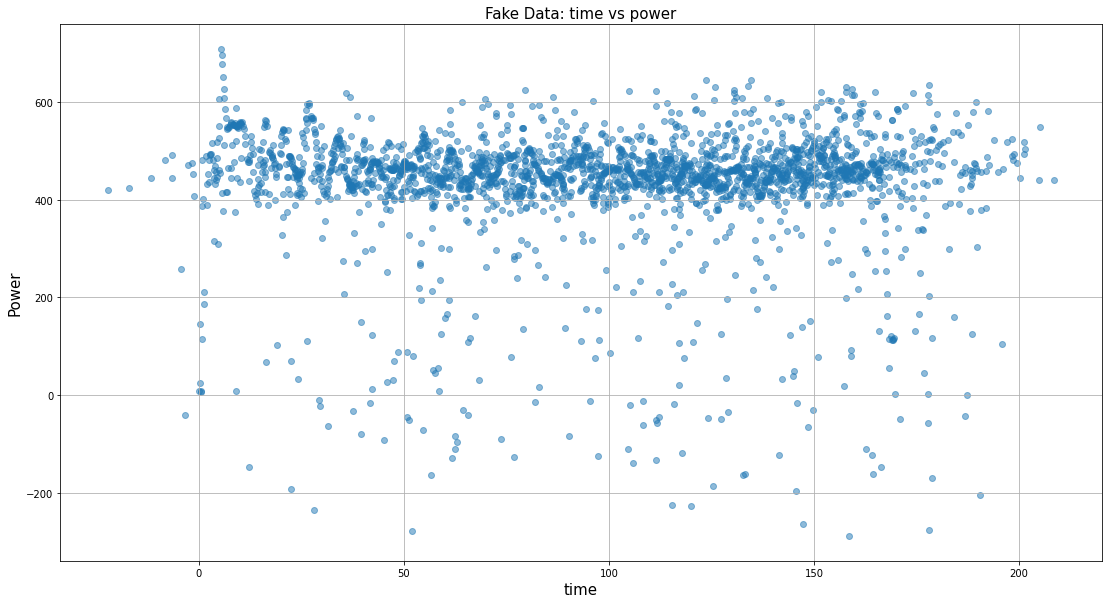

In [15]:
# Displaying synthetic data graph (generated ones)

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
ax.scatter(gen_x['time'], gen_y, alpha=0.5)

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('Power', fontsize=15)
ax.set_title('Fake Data: time vs power', fontsize=15)

ax.grid(True)
fig.tight_layout()

plt.show()